In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Import Clean data
clean_df = pd.read_pickle("train_set.pkl")
val_df = pd.read_pickle("val_set.pkl")

# Convert NumPy arrays to JSON before saving
clean_df['Wafer_Map'] = clean_df['Wafer_Map'].apply(lambda x: json.dumps(x.tolist()))
val_df['Wafer_Map'] = val_df['Wafer_Map'].apply(lambda x: json.dumps(x.tolist()))

# Save to CSV
clean_df.to_csv("train_set.csv", index=False)
val_df.to_csv("val_set.csv", index=False)

# Import Clean data
clean_df = pd.read_csv('train_set.csv')
val_df = pd.read_csv('val_set.csv')

# For WSL2
# data_dir = "/mnt/c/Users/custu/My Drive/MSDS 422/M10"
# clean_df = pd.read_csv(f"{data_dir}/train_set.csv")
# val_df = pd.read_csv(f"{data_dir}/val_set.csv")

# Decode JSON to NumPy arrays
clean_df['Wafer_Map'] = clean_df['Wafer_Map'].apply(lambda x: np.array(json.loads(x), dtype=np.uint8))
val_df['Wafer_Map'] = val_df['Wafer_Map'].apply(lambda x: np.array(json.loads(x), dtype=np.uint8))



In [7]:
import tensorflow as tf

# Set GPU as default
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [8]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

### CNN Models

Trial 1 Complete [00h 00m 20s]
val_categorical_accuracy: 0.8455062508583069

Best val_categorical_accuracy So Far: 0.8455062508583069
Total elapsed time: 00h 00m 20s
{'conv1_filters': 16, 'dropout1': 0.0, 'conv2_filters': 64, 'dropout2': 0.0, 'conv3_filters': 128, 'dropout3': 0.0, 'dense_units': 256, 'dropout_fc': 0.4, 'dense_units2': 128, 'dropout_fc2': 0.4, 'learning_rate': 0.001, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
Epoch 1/50
180/180 [==============================] - 2s 10ms/step - loss: 1.1213 - categorical_accuracy: 0.5943 - precision_1: 0.7518 - recall_1: 0.4451 - val_loss: 1.4996 - val_categorical_accuracy: 0.0385 - val_precision_1: 0.1982 - val_recall_1: 0.0248
Epoch 2/50
180/180 [==============================] - 2s 9ms/step - loss: 0.7394 - categorical_accuracy: 0.7307 - precision_1: 0.8247 - recall_1: 0.6299 - val_loss: 2.7458 - val_categorical_accuracy: 0.0729 - val_precision_1: 0.1745 - val_recall_1: 0.0621
Epoch 3/50
180/180

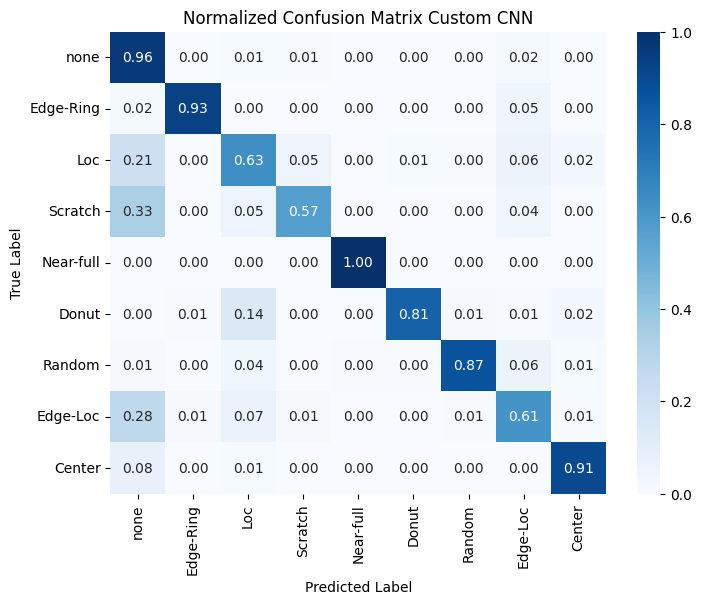

              precision    recall  f1-score   support

        none       0.98      0.96      0.97     36858
   Edge-Ring       0.97      0.93      0.95      2420
         Loc       0.55      0.63      0.59       898
     Scratch       0.33      0.57      0.42       298
   Near-full       0.88      1.00      0.94        37
       Donut       0.90      0.81      0.85       139
      Random       0.79      0.87      0.83       217
    Edge-Loc       0.49      0.61      0.55      1297
      Center       0.86      0.91      0.88      1074

    accuracy                           0.94     43238
   macro avg       0.75      0.81      0.77     43238
weighted avg       0.95      0.94      0.94     43238



In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.optimizers.schedules as schedules
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras_tuner as kt

random_state = 2

# Prepare data
X_train = np.stack(clean_df['Wafer_Map'].values)  
X_train = X_train.reshape(-1, 45, 45, 1).astype('float32')  
X_test = np.stack(val_df['Wafer_Map'].values)  
X_test = X_test.reshape(-1, 45, 45, 1).astype('float32') 

# Encode target variable
label_encoder = pd.factorize(clean_df['Defect_Class'])
y_train = label_encoder[0] 
y_classes = label_encoder[1]
y_test = val_df['Defect_Class'].map({cls: i for i, cls in enumerate(y_classes)}).fillna(-1).astype(int).values

# Convert to OHE
y_train = to_categorical(y_train, num_classes=len(y_classes))
y_test = to_categorical(y_test, num_classes=len(y_classes))

# Build model
def build_model(hp):
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv2D(filters=hp.Choice('conv1_filters', values=[16]),kernel_size=(5, 5), activation='relu', input_shape=(45, 45, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Choice('dropout1', values=[0.0]))) 

    # Second Convolutional Block
    model.add(Conv2D(filters=hp.Choice('conv2_filters', values=[64]),  kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Choice('dropout2', values=[0.0])))  

    # Third Convolutional Block
    model.add(Conv2D(filters=hp.Choice('conv3_filters', values=[128]), kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Choice('dropout3', values=[0.0]))) 

    # Dense Layers + Output
    model.add(Flatten())
    model.add(Dense(hp.Choice('dense_units', values=[256]),activation='relu'))
    model.add(Dropout(hp.Choice('dropout_fc', values=[0.4]))) 
    model.add(Dense(hp.Choice('dense_units2', values=[128]),activation='relu'))
    model.add(Dropout(hp.Choice('dropout_fc2', values=[0.4]))) 
    model.add(Dense(9, activation='softmax'))

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.001])),
        loss='categorical_crossentropy',metrics=['categorical_accuracy', Precision(), Recall()])
    return model

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_categorical_accuracy',
    max_epochs=30, 
    factor=3, 
    directory='hyperband_tuning',
    project_name='CNN_Model_1_v2_Test'
)
tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

# Start time
import time
start_time = time.time()


# Train
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test), callbacks=[early_stopping])

# End time
end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")

# Evaluate
start_time = time.time()
eval_results = best_model.evaluate(X_test, y_test)
end_time = time.time()
print(f"Evaluation Time: {end_time - start_time:.2f} seconds")    
print(f"Validation Accuracy: {eval_results[1]:.4f}")    
print(f"Training Accuracy: {history.history['categorical_accuracy'][-1]:.4f}")

# Get predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true_classes = np.argmax(y_test, axis=1) 

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=y_classes, yticklabels=y_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix Custom CNN')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=y_classes))

In [10]:
# Print model
print(best_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 41, 41, 16)        416       
                                                                 
 batch_normalization_3 (Batc  (None, 41, 41, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 20, 20, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 20, 20, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 64)        9280      
                                                                 
 batch_normalization_4 (Batc  (None, 18, 18, 64)      

In [11]:
from pathlib import Path

# Choose an output directory (can be temporary)
out_dir = Path("exported_models/cnn")
out_dir.mkdir(parents=True, exist_ok=True)

model_path = out_dir / "cnn_model.keras"
best_model.save(model_path)

print(f"Saved model to: {model_path.resolve()}")

import json

classes = list(y_classes)  # from your training code
with open(out_dir / "classes.json", "w") as f:
    json.dump(classes, f, indent=2)

print("Saved classes.json:", classes)


Saved model to: C:\Users\custu\My Drive\MSDS 458\Report\Testing Notebooks\exported_models\cnn\cnn_model.keras
Saved classes.json: ['none', 'Edge-Ring', 'Loc', 'Scratch', 'Near-full', 'Donut', 'Random', 'Edge-Loc', 'Center']
